# Introduction to PyTorch

## Additional libraries

Install the following:

* PyTorch (CPU version is sufficient, you don't need GPU support) - Installation instruction on https://pytorch.org/
* matplotlib and scikit-learn - these two should be available in your Python distribution (e.g., using pip: `pip install scikit-learn matplotlib`)

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Linear regression

### Data preparation

For this task we'll consider the problem of predicting houses prices in California. We begin by loading the dataset using `fetch_california_housing`. The returned object contains a few fields:

* `data` - the matrix of features
* `feature_names` - names of the features
* `target` - the values to predict

In [2]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

Let's see the feature names:

In [3]:
dataset['feature_names']
#dataset['data']
#dataset['target']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Some of them are not very meaningful, but fortunately we can proceed without detailed understanding of the dataset. If you are interested, some details are available at https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

Now we convert the data to `torch.Tensor`, a PyTorch-specific representation of a tensor (a tensor is a generalization of a matrix to more than 2 dimensions). The `dtype` parameter forces conversion to floating-point numbers. The output of the cell is the size of the matrices. The output of the cell are the shapes of both tensors - `X` is 20640 rows by 8 columns and `y` is a vector of 20640 values

In [4]:
X = torch.tensor(dataset['data'], dtype=torch.float)
y = torch.tensor(dataset['target'], dtype=torch.float)

X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640]))

We then split the data randomly into three subsets: a training set consisting of 70\% of the learning examples, a validation set consisting of 10\% and a test set consisting of the remaining 20\%.

In [5]:
n, p = X.shape
n_training = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
X = X[indices]
y = y[indices]
X_training = X[:n_training, :]
y_training = y[:n_training]
X_validation = X[n_training:n_training+n_validation, :]
y_validation = y[n_training:n_training+n_validation]
X_test = X[n_training+n_validation:, :]
y_test = y[n_training+n_validation:]

print("Training:", X_training.shape, y_training.shape)
print("Validation:", X_validation.shape, y_validation.shape)
print("Test:", X_test.shape, y_test.shape)

Training: torch.Size([14447, 8]) torch.Size([14447])
Validation: torch.Size([2064, 8]) torch.Size([2064])
Test: torch.Size([4129, 8]) torch.Size([4129])


### Building a simple regressor

PyTorch is based on modules (objects of the class `torch.nn.Module`), which are composed into a compution graph. Each module may use parameters (objects of the class `torch.nn.Parameter`), and for each such an object it is possible to automatically compute gradients and optimize them according to some cost function.

We begin by constructing a single linear layer, that is, a layer implementing the operation $\hat{y} = Xw + b$

In [6]:
regressor = nn.Linear(p, 1) # p input features, 1 output feature

To evaluate the performance we use mean-squared error. While PyTorch offers a ready to use implementation as the class `torch.nn.MSELoss()`, this time we implement it manually as an example. The main point is to inherit from the class `torch.nn.Module` and then to override the method `forward`, which is responsible for performing computations in the forward direction of the computation graph. Computations in the backward direction (that is, gradient flow) are derrived automatically.

In [7]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

We would like to optimize the vector `w` and `b` automatically during the learning. To this end, we use the class `torch.optim.Adam`, which implements some extensions of the graident descent algorithm. We construct the object `opt`, which is responsible for optimizing the regressor's parameters, obtained by calling `regressor.parameters()`.

In [8]:
opt = optim.Adam(regressor.parameters())

### Starting computations

We implement mini-batch learning over `n_epoch` epochs. Within each epoch:
1. The indices of the training set are shuffled.
2. We iterate over these indices, retrieving `batch_size` of them every time. We use these indices to select examples used in the current learning step.
3. We zero the gradients stored by the optimizer (`opt.zero_grad()`)
4. We execute the regressor and compute the mean-squared error (MSE).
5. We compute the gradients (`mse_value.backward()`) and apply them (`opt.step()`) to update the parameters of the regressor
6. We store the value of MSE. We call the `detach()` method to detach the MSE from its gradients. This enables passing the values to other libraries like matplotlib.

After an epoch is completed, we average the collected MSEs and store the value.

In [9]:
mse_values = []
batch_size = 100
n_epoch = 10
for epoch in range(n_epoch):
    indices = np.random.permutation(n_training)
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_training[indices_batch, :]
        y_batch = y_training[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.detach())
    mse_values.append(np.mean(mse_epoch))    

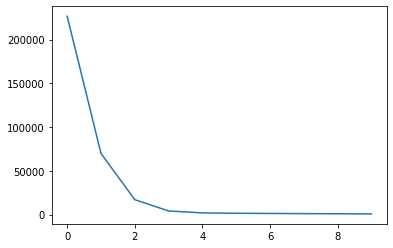

In [10]:
plt.plot(mse_values)
plt.show()

Execute the two preceeding cells of the code again. Because the regressor and the optimizer were not created anew, so the parameters are already optimized and the obtained charts are vastly different. In order to return to the initial state it is necessary to create new obiect `regressor` and `opt`.

### Task 1: Early stopping

Implement early stopping: after each epoch of learning compute the value of MSE using the sets `X_validation` and `y_validation`. Stop the learning process if there is no improvement over the last 10 epochs with regard to the value of MSE on the validation set. Store values of `mse` for training and for validation (respecitvely in `training_mses` and `validation_mses`), the second cell of code will plot them. Print out the number of the epoch when the learning process was stopped.

Hints and remarks:
* Observe that we must call the methods `regressor.train()` and `regressor.eval()` to switch the module between the training mode and the evaluation mode. 
* Remeber not to call `opt.step()` after performing the computation on the validation set, to not update the weights of the model. Similarly, you don't need to compute gradients during this step.
* You don't need to shuffle the validation set, nor go over it using batches.
* You may want to print out the epoch number and the value of the MSE on the validation set every time you find a better value. In the beginning you should expect a better value more or less every epoch and the decrease in MSE will be step, with time the decreases will diminishi and you'll hit a better value only every few epochs

In [11]:
import math

regressor = nn.Linear(p, 1) # p input features, 1 output feature
opt = optim.Adam(regressor.parameters())

training_mses = []
validation_mses = []
batch_size = 100
n_epoch = 10000
worst_values = 0
best_mse = math.inf
for epoch in range(n_epoch):
    regressor.train()
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_training[indices_batch, :]
        y_batch = y_training[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.detach())
    training_mses.append(np.mean(mse_epoch))
    regressor.eval()
    current_pred_mse = regressor(X_validation).reshape((-1,))
    current_mse = (mse(current_pred_mse, y_validation)).detach()
    validation_mses.append(current_mse)
    if current_mse < best_mse:
        best_mse = current_mse
        worst_values = 0
        print("Better value epoch: ", epoch + 1)
    else:
        worst_values += 1

    if worst_values == 10:
        print("Last epoch: ", epoch + 1)
        break

Better value epoch:  1
Better value epoch:  2
Better value epoch:  3
Better value epoch:  4
Better value epoch:  5
Better value epoch:  6
Better value epoch:  7
Better value epoch:  8
Better value epoch:  9
Better value epoch:  10
Better value epoch:  11
Better value epoch:  12
Better value epoch:  13
Better value epoch:  14
Better value epoch:  15
Better value epoch:  16
Better value epoch:  17
Better value epoch:  18
Better value epoch:  19
Better value epoch:  20
Better value epoch:  21
Better value epoch:  22
Better value epoch:  23
Better value epoch:  24
Better value epoch:  25
Better value epoch:  26
Better value epoch:  27
Better value epoch:  28
Better value epoch:  29
Better value epoch:  30
Better value epoch:  31
Better value epoch:  32
Better value epoch:  33
Better value epoch:  34
Better value epoch:  35
Better value epoch:  36
Better value epoch:  37
Better value epoch:  38
Better value epoch:  44
Better value epoch:  45
Better value epoch:  46
Better value epoch:  47
B

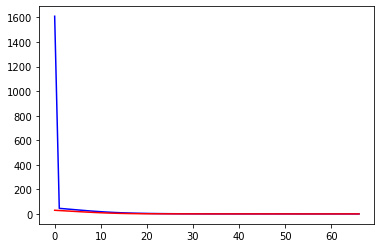

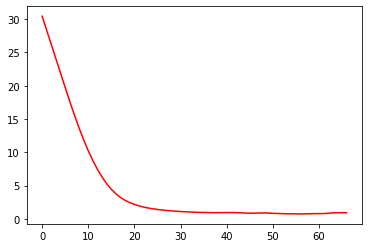

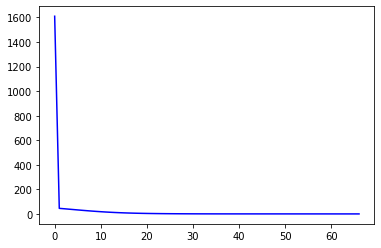

In [12]:
plt.plot(training_mses, 'b') # plot training errors in blue
plt.plot(validation_mses, 'r') # plot validation errors in red
plt.show()

#Since the lines are not fully shown, I decided to add two more plots depicting each set separately.
plt.plot(validation_mses, 'r') # plot validation errors in red
plt.show()

plt.plot(training_mses, 'b') # plot training errors in blue
plt.show()

## Classification

The second part is concerned with the classification task. We begin by downloading the MNIST dataset, consisting of 70.000 examples of handwritten digits (0-9), represented as grayscale images of 28x28 pixels. We use the function `fetch_openml` that downloads the data from [https://www.openml.org/](https://www.openml.org).

In [13]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [ ]:
X = torch.tensor(mnist.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist.target])

Lets inspect some examples. The digit in the top-right corner of each image is not a part of the image itself, but rather the label of the image, displayed using `ax.text` in the code below.

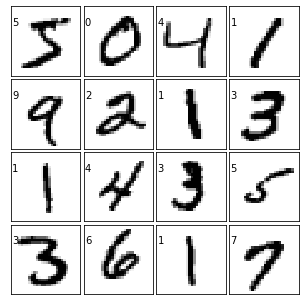

In [93]:
fig = plt.figure(figsize = (4,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(X[i].reshape(28, 28),cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(y[i].item()))

The following code splits the data into three subsets: training, validation and test. This time, instead of representing the sets as raw tensors, we wrap each of them into an object of the class `torch.utils.data.TensorDataset`, which then enables shuffling, grouping into mini-batches and iterating over using `torch.utils.data.DatasetLoader`.

In [94]:
n, p = mnist.data.shape
k = 10 # number of classes
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
train_indices = indices[:n_train]
validation_indices = indices[n_train:n_train+n_validation]
test_indices = indices[n_train+n_validation:]

ds_train = data.TensorDataset(X[train_indices,:], y[train_indices])
ds_validation = data.TensorDataset(X[validation_indices,:], y[validation_indices])
ds_test = data.TensorDataset(X[test_indices,:], y[test_indices])

### Logistic regression

We create a simple logisitc regression model, learning on the raw pixels of the images. The matrix of the feature weights (here: pixels) is of the size $p \times k$, i.e., $p$ weights for each of the $k$ classes. The model computes logits, i.e., the output of the logistic  regression **before** applying the softmax function. In the output, each row corresponds to a single example and each column to a single class. Should each row be normalized using the softmax function, each row would be a probability distribution.

In [95]:
model = nn.Linear(p, k)

As the loss function we will use *cross entropy* and perform the optimization using the Adam optimizer.

In [96]:
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

We create an auxiliary function to compute the classification accuracy. For each row of the `logits` matrix we select the number of the column with the highest value and compare it with the expected (true) value. This way we obtain a vector of 0s and 1s, which are then averaged to compute the accuracy.

In [97]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

The remainder is very similar to the linear regression: during each of the `n_epoch` epochs, we enable the training mode (`model.train()`), create a data loder ( `torch.utils.data.DataLoader`) to handle shuffling and creating batches for us and then iterate over the loader, computing loss and gradients. Then we evaluate by computing the accuracy on the validation set.

In [98]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100

In [99]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)

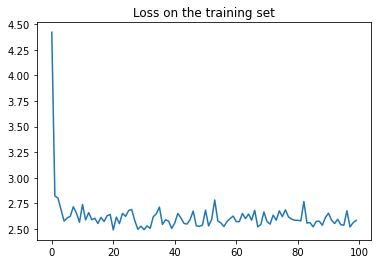

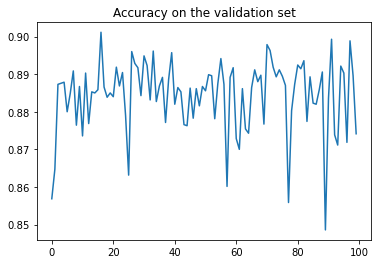

In [100]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

### Task 2: Early stopping in classification

Copy and modify the code presented above so that it uses early stopping instead of training over a constant number of epochs, taking into account accuracy on the validation set. Include creating a new model, a new optimizer and a new loss function.

In [101]:
# Your code here, possibly in more cells than one
new_model = nn.Linear(p, k)
new_cost = torch.nn.CrossEntropyLoss()
new_opt = optim.Adam(new_model.parameters())

loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100
worst_values = 0
best_acc = -math.inf

In [102]:
for epoch in range(n_epoch):
    new_model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        new_opt.zero_grad()
        logits = new_model(X_batch)
        loss = new_cost(logits, y_batch)
        loss.backward()
        new_opt.step()        
        epoch_loss.append(loss.detach())
    new_model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = new_model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)
    if acc > best_acc:
        best_acc = acc
        worst_values = 0
    else:
        worst_values += 1
    
    if worst_values == 10:
        print("Last epoch: ", epoch + 1)
        break

Last epoch:  20


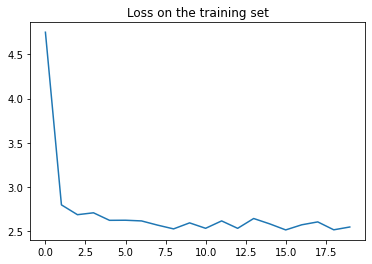

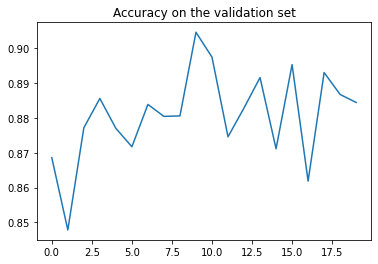

In [103]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

### Task 3: A neural network with a hidden layer

A logistic regression is a neural network without hidden layers. Use the code presented above and extend it with a hidden layer of 500 neurons. In order to connect a few objects of the type `torch.nn.Module` into a sequence use the class `torch.nn.Sequential`. Use the leaky ReLU function (`torch.nn.LeakyReLU`) to implement non-linearity. 

Implement early stopping. During the training collect the loss and accuracy on the  training set and the accuracy on the validation set and plot them. If the training takes too much time, modify `batch_size` and/or the number of neurons in the hidden layer.

In [105]:
model = nn.Sequential(
    nn.Linear(p, 500), # replace ... with creating a hidden layer
    nn.LeakyReLU(),  # non-linearity
    nn.Linear(500, k)) # replace ... with creating an output layer

In [106]:
# Your code here, possibly in more cells than one
new_cost = torch.nn.CrossEntropyLoss()
new_opt = optim.Adam(model.parameters())

loss_values = []
acc_values = []
batch_size = 100
n_epoch = 500
worst_values = 0
best_acc = -math.inf

In [107]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        new_opt.zero_grad()
        logits = model(X_batch)
        loss = new_cost(logits, y_batch)
        loss.backward()
        new_opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)
    if acc > best_acc:
        best_acc = acc
        worst_values = 0
    else:
        worst_values += 1
    
    if worst_values == 10:
        print("Last epoch: ", epoch + 1)
        break

Last epoch:  47


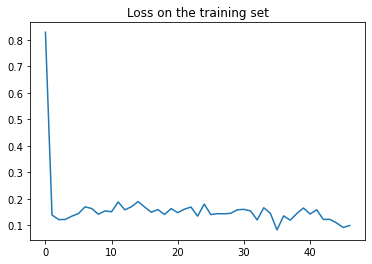

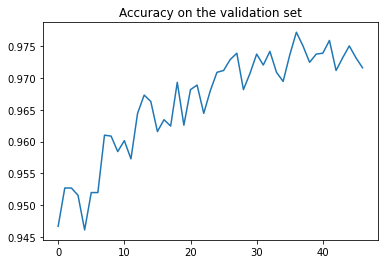

In [108]:
plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()